In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 3.2 MB/s 
     |████████████████████████████████| 3.1 MB 10.1 MB/s 
     |████████████████████████████████| 3.3 MB 39.7 MB/s 
     |████████████████████████████████| 1.2 MB 37.3 MB/s 
     |████████████████████████████████| 61 kB 464 kB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=ec223317a8d311b7ce6746edbf34a835209f614e3d5f9f7a0c1ddc4d009ca904
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [41]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
df = pd.read_csv('data/folketinget_data_latest.csv')
df["sagstrin_sag_titel"] = df[["sagstrin_sag_titel", "konklusion", "sagstrin_sag_titelkort"]].astype(str)

In [30]:
df['merged'] = df['sagstrin_sag_titel']+ ' ' +df['sagstrin_sag_titelkort']
df = df[df['merged'].notnull()]
text_without_processing = list(df['merged'].values)
len(text_without_processing)

1663

In [31]:
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text_without_processing, show_progress_bar=True, normalize_embeddings = False)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/52 [00:00<?, ?it/s]

In [32]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [33]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(umap_embeddings)

In [34]:
print(Counter(cluster.labels_))

Counter({20: 299, 13: 291, -1: 243, 17: 194, 4: 192, 0: 54, 1: 53, 10: 50, 2: 49, 18: 41, 19: 29, 16: 27, 15: 22, 11: 15, 7: 15, 3: 15, 12: 14, 5: 14, 8: 12, 6: 12, 14: 11, 9: 11})


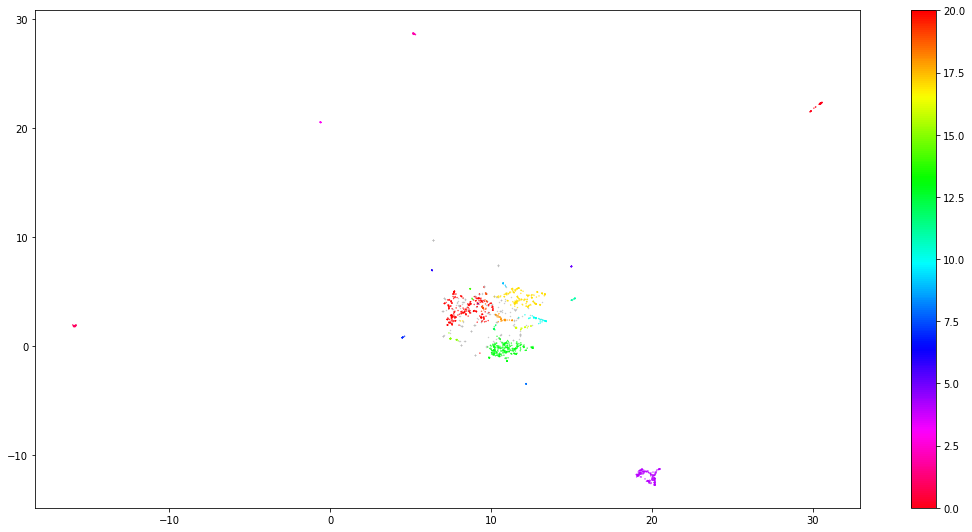

In [35]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [72]:
from nltk.tokenize import word_tokenize

with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]

def remove_stopwords(token: str) -> str:
    return token if token not in stopwords else ''

def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)

def remove_numbers(text, str) -> str:
    return re.sub(r'\d+', '', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)

import string 
    
def remove_punctuation(text: str) -> str:
    """BUT DO NOT REMOVE HASHTAGS OR MENTIONS"""
    regexp = re.compile(r'([#@]\w+)')
    return text if regexp.search(text) else re.sub(f'[{string.punctuation}]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

def remove_standalone_numbers(text: str) -> str:
    return re.sub(f'(?<!\S)\d+(?!\S)', '', text)

def split_by_space(text: str) -> List[str]:
    return text.split(' ')


def save_json(path, container) -> None:
    """write dict to path."""
    print(f"Saving json to {path}")
    with open(path, "w") as outfile:
        json.dump(container, outfile)

In [45]:
text_list = text

tokenized_text = [[token for token in word_tokenize(i)] for i in text_list]

print(tokenized_text[:2])

preprocessing_func = [remove_punctuation, str.lower, is_website_token, remove_stopwords, remove_standalone_numbers]

all_tokenizer_text = []

for token_text in tokenized_text:
    post_processed = []
    for token in token_text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_processed.append(token)
    all_tokenizer_text.append(' '.join(post_processed))

print(all_tokenizer_text[:2])
print(len(all_tokenizer_text))

[['Det', 'går', 'økonomisk', 'bedre', 'end', 'længe', '.', 'Siden', '2015', 'er', 'der', 'truffet', 'mange', 'beslutninger', ',', 'som', 'trækker', 'Danmark', 'i', 'den', 'rigtige', 'retning', '.', 'Flere', 'er', 'i', 'privat', 'beskæftigelse', ',', 'og', 'færre', 'er', 'på', 'passiv', 'offentlig', 'forsørgelse', '.', 'Der', 'er', 'positiv', 'udvikling', 'i', 'alle', 'landsdele', ',', 'men', 'der', 'skal', 'fortsat', 'tages', 'initiativer', 'for', 'at', 'sikre', 'et', 'Danmark', 'i', 'bedre', 'balance', '.', 'Vi', 'er', 'optaget', 'af', 'at', 'sikre', 'et', 'bedre', 'klima', 'og', 'miljø', 'for', 'de', 'kommende', 'generationer', '.', 'Der', 'er', 'gennemført', 'helt', 'nødvendige', 'stramninger', 'af', 'udlændingepolitikken', '.', 'Retningen', 'skal', 'fastholdes', ',', 'så', 'asyltallet', 'fortsat', 'holdes', 'på', 'et', 'meget', 'lavt', 'niveau', '.', 'Samtidig', 'skal', 'praksis', 'ændres', ',', 'så', 'midlertidigt', 'ophold', 'også', 'reelt', 'bliver', 'midlertidigt', '.', 'Det', 

In [47]:
print(len(all_tokenizer_text))
print(len(text))

1663
1663


In [49]:
docs_df = pd.DataFrame(all_tokenizer_text , columns=["Doc"])
docs_df['Original Docs'] = text
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#### Group by topic and select a sample

In [70]:
docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/folketinget_large_clusters.json')

### Tf-idf on docs from each cluster

In [52]:
def c_tf_idf(documents, m, ngram_range=(1, 3)):
    count = CountVectorizer(tokenizer = split_by_space, stop_words = None, ngram_range = (1,1)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [55]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
21,20,299
14,13,291
0,-1,243
18,17,194
5,4,192
1,0,54
2,1,53
11,10,50
3,2,49
19,18,41


In [73]:
top_n_words[3]
import json
save_json('data/folketinget_top_n_words_large_cluster.json', top_n_words)

Saving json to data/folketinget_top_n_words_large_cluster.json


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(8):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [ ]:
# Get topic ids of alle clusters with more than 200 documents
topic_subset = topic_sizes[topic_sizes.Doc > 100]
topic_subset = list(topic_subset.Topic.values)

In [ ]:
print(topic_subset)
len(top_n_words)
print(topic_sizes.head(20))
print(top_n_words.keys())

### Reduce large clusters

Counter({5: 75, 4: 40, 1: 33, 8: 31, 7: 22, 9: 21, 10: 16, 0: 16, 2: 16, 3: 14, 6: 12, -1: 3})


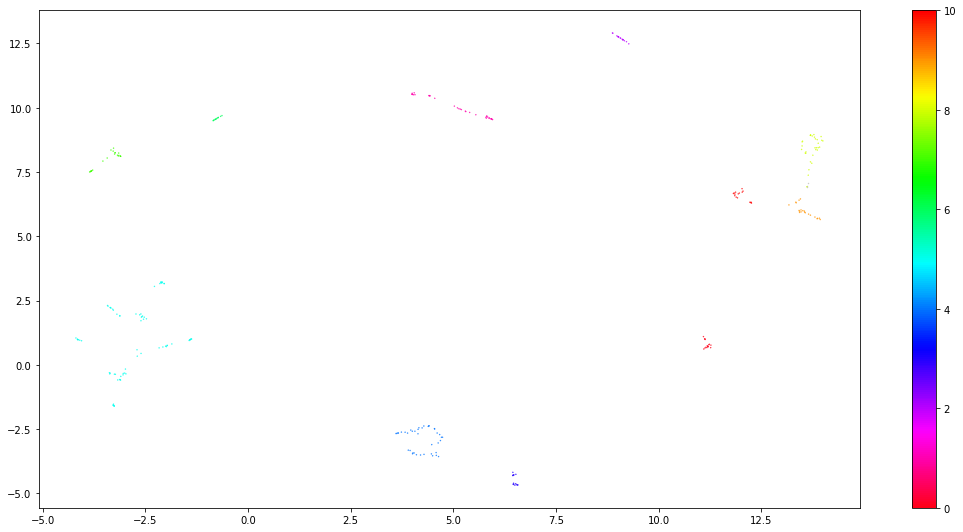

In [74]:
# Reduce large clusters

# Get large cluster idx
large_cluster_idx = [idx for idx, label in enumerate(cluster.labels_) if label == 20]
large_cluster_embeddings = umap_embeddings[large_cluster_idx,:]

# Reduce dim
large_umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(large_cluster_embeddings)


large_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(large_umap_embeddings)

print(Counter(large_cluster.labels_))

# Prepare data
large_umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(large_cluster_embeddings)
large_result = pd.DataFrame(large_umap_data, columns=['x', 'y'])
large_result['labels'] = large_cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = large_result.loc[large_result.labels == -1, :]
clustered = large_result.loc[large_result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [78]:
docs_df = pd.DataFrame([all_tokenizer_text[i] for i in large_cluster_idx] , columns=["Doc"])
docs_df['Original Docs'] = [text[i] for i in large_cluster_idx]
docs_df['Topic'] = large_cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/folketing_small_subclusters.json')

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
6,5,75
5,4,40
2,1,33
9,8,31
8,7,22
10,9,21
1,0,16
3,2,16
11,10,16
4,3,14


In [84]:
top_n_words[9]

[('miljøbeskyttelse', 0.10832927776820112),
 ('lov', 0.10208096184863764),
 ('ændring', 0.09517179750388319),
 ('forslag', 0.08543562834423579),
 ('fast', 0.08424108402636094),
 ('havbrug', 0.07652542870700507),
 ('digital', 0.06709485482183573),
 ('naturbeskyttelse', 0.0658383284213019),
 ('adgang', 0.0631808130197707),
 ('visse', 0.058534670969006844),
 ('nedlæggelse', 0.054694640526739564),
 ('ejerskifte', 0.054694640526739564),
 ('brændsel', 0.054694640526739564),
 ('udskiftning', 0.054694640526739564),
 ('planer', 0.054694640526739564),
 ('arealer', 0.054694640526739564),
 ('etablere', 0.054694640526739564),
 ('naturnationalparker', 0.054694640526739564),
 ('fyringsanlæg', 0.054694640526739564),
 ('pligt', 0.05101695247133671),
 ('ejendom', 0.046383613480261966),
 ('obligatorisk', 0.044729903214557165),
 ('kommunikation', 0.04333171110728044),
 ('miljøvurdering', 0.0429780012960872),
 ('programmer', 0.0429780012960872),
 ('projekter', 0.0429780012960872),
 ('konkrete', 0.042978001

In [85]:
save_json('data/folketinget_top_n_words_small_subcluster.json', top_n_words)

Saving json to data/folketinget_top_n_words_small_subcluster.json
